Este cuaderno de ipython es propiedad de:
El laboratorio de Diseño de Fármacos de Concepción. En convenio con:
Datagen Limitada, Chile.
* Autor : Dr. Alexis Salas Burgos
* Fecha : Noviembre 2015
* Versión: 1.0

Requerimientos Enviromental bio (pip install):
* mdtraj
* tables
* prody
* scipy

In [1]:
import numpy as np
import mdtraj as md
from itertools import combinations

def best_hummer_q(traj, native):
    """Compute the fraction of native contacts according the definition from
    Best, Hummer and Eaton [1]
    
    Parameters
    ----------
    traj : md.Trajectory
        The trajectory to do the computation for
    native : md.Trajectory
        The 'native state'. This can be an entire trajecory, or just a single frame.
        Only the first conformation is used
        
    Returns
    -------
    q : np.array, shape=(len(traj),)
        The fraction of native contacts in each frame of `traj`
        
    References
    ----------
    ..[1] Best, Hummer, and Eaton, "Native contacts determine protein folding
          mechanisms in atomistic simulations" PNAS (2013)
    """
    
    BETA_CONST = 50  # 1/nm
    LAMBDA_CONST = 1.8
    NATIVE_CUTOFF = 0.45  # nanometers
    
    # get the indices of all of the heavy atoms
    heavy = native.topology.select_atom_indices('heavy')
    # get the pairs of heavy atoms which are farther than 3
    # residues apart
    heavy_pairs = np.array(
        [(i,j) for (i,j) in combinations(heavy, 2)
            if abs(native.topology.atom(i).residue.index - \
                   native.topology.atom(j).residue.index) > 3])
    
    # compute the distances between these pairs in the native state
    heavy_pairs_distances = md.compute_distances(native[0], heavy_pairs)[0]
    # and get the pairs s.t. the distance is less than NATIVE_CUTOFF
    native_contacts = heavy_pairs[heavy_pairs_distances < NATIVE_CUTOFF]
    print("Number of native contacts", len(native_contacts))
    
    # now compute these distances for the whole trajectory
    r = md.compute_distances(traj, native_contacts)
    # and recompute them for just the native state
    r0 = md.compute_distances(native[0], native_contacts)
    
    q = np.mean(1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0))), axis=1)
    return q 

In [41]:
import os
directorio_work = "/Users/alsalas/Desktop/UreI_pH6/"
os.chdir(directorio_work)

In [46]:
#Calcular el rmsf promedio por aminoacido
for cadena in ['A','B','C','D','E','F']:
    pdb = "UreI_pH6_Cad%s_c2.pdb"%cadena
    dcd = "UreI_pH6_cad%s.dcd"%cadena
    traj = md.load_dcd(dcd, top=pdb)
    traj = traj[500::10]
    traj0 = md.load_pdb(pdb)
    # the unitcell info in this PDB happens to be wrong, so lets
    # just remove it
    traj.unitcell_vectors = None

    # just for example, use the first frame as the 'native' conformation
    exec('q%s = best_hummer_q(traj, traj0)'%cadena)

ValueError: xyz must be shape (Any, 3109, 3). You supplied  (2500, 3100, 3)

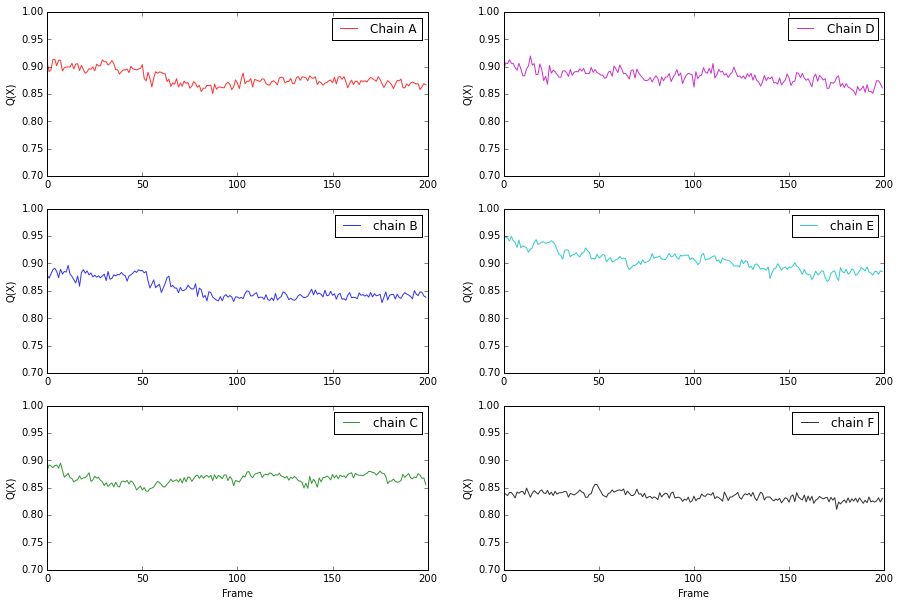

In [44]:
import pylab
import matplotlib.pyplot as plt
import numpy as np

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)#, sharex='col', sharey='row')

x = range(len(qA))
ax1.plot(x, qA, "r-", linewidth = 1, alpha = 0.8, label = "Chain A")
ax2.plot(x, qD, "m-", linewidth = 1, alpha = 0.8, label = "Chain D")
ax3.plot(x, qB, "b-", linewidth = 1, alpha = 0.8, label = "chain B")
ax4.plot(x, qE, "c-", linewidth = 1, alpha = 0.8, label = "chain E")
ax5.plot(x, qC, "g-", linewidth = 1, alpha = 0.8, label = "chain C")
ax6.plot(x, qF, "k-", linewidth = 1, alpha = 0.8, label = "chain F")

limite_inf = 0.70; limite_sup = 1
for i in range(6): exec("ax%d.set_ylim([limite_inf, limite_sup])"%(i+1))
    
ax5.set_xlabel("Frame")
ax6.set_xlabel("Frame")
ax1.set_ylabel(r'Q(X)')
ax2.set_ylabel(r'Q(X)')
ax3.set_ylabel(r'Q(X)')
ax4.set_ylabel(r'Q(X)')
ax5.set_ylabel(r'Q(X)')
ax6.set_ylabel(r'Q(X)')
ax1.legend(loc=1)
ax2.legend(loc=1)
ax3.legend(loc=1)
ax4.legend(loc=1)
ax5.legend(loc=1)
ax6.legend(loc=1)

fig.set_size_inches(15, 10, forward=True)

pylab.savefig("Q_Chain.svg", dpi=200)
pylab.savefig("Q_Chain.png", dpi=200)
